
Final quantum state (states' amplitudes):
Statevector([ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j],
            dims=(2, 2))


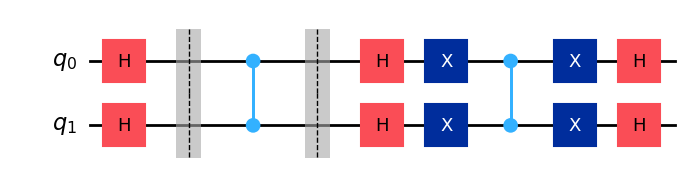

In [15]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Circuit definition
grover_circuit = QuantumCircuit(2)

# Initial superposition
grover_circuit.h([0, 1])
grover_circuit.barrier()

# Oracle
grover_circuit.cz(0, 1)
grover_circuit.barrier()

# Diffuser
grover_circuit.h([0, 1])
grover_circuit.x([0, 1])
grover_circuit.cz(0, 1)
grover_circuit.x([0, 1])
grover_circuit.h([0, 1])

# Measurement
final_state = Statevector.from_instruction(grover_circuit)

# Results
print("\nFinal quantum state (states' amplitudes):")
print(final_state)
grover_circuit.draw(output="mpl")